# Imporint necessary libraries

In [ ]:
import numpy as np
import torch
import cv2
import os
import torchvision
from torchvision import datasets, models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import time
import copy

from torch.optim import lr_scheduler, Adam, SGD
import torch.nn.functional as F

# Mounting xray images from google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
unbalancedFileDir = '/content/drive/Shareddrives/Groupproject/unbalancedData/'

In [ ]:
balancedFileDir = '/content/drive/Shareddrives/Groupproject/balancedData/'

# Counting images in the folder

In [ ]:
def count_images_from_folder(folder):
  imageCount = 0
  for dirName, subdirList, fileList in os.walk(folder):
    for f in fileList:
      path = os.path.join(dirName,f)
      imageCount += 1
  print(f'Total of {imageCount} images.')

In [ ]:
count_images_from_folder(unbalancedFileDir)

Total of 5856 images.


In [ ]:
count_images_from_folder(balancedFileDir)

Total of 3166 images.


# **Transforming images using dataloader**

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [ ]:
test_transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

In [ ]:
testImage = Image.open('/content/drive/Shareddrives/Groupproject/unbalancedData/test/PNEUMONIA/person51_bacteria_247.jpeg')
testImage = testImage.convert("RGB")

In [ ]:
testImage.size

(1322, 1018)

In [ ]:
testTransformedImage = test_transforms(testImage)
testTransformedImage.shape
testTransformedImage = testTransformedImage.permute(1,2,0)


In [ ]:
testTransformedImage.shape

torch.Size([224, 224, 3])

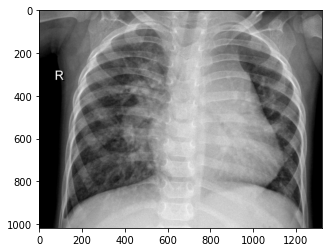

In [ ]:
plt.imshow(testImage)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


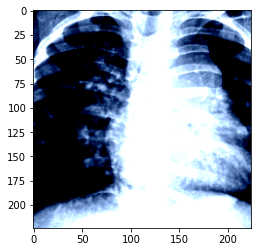

In [ ]:
plt.imshow(testTransformedImage)

In [ ]:
unbalanced_image_datasets = {x: datasets.ImageFolder(os.path.join(unbalancedFileDir, x), data_transforms[x]) for x in ['test','train','val']}
unbal_dataloaders = {x: torch.utils.data.DataLoader(unbalanced_image_datasets[x], batch_size=8,
                                             shuffle=True, num_workers=2)
              for x in ['test','train', 'val']}
unbal_dataset_sizes = {x: len(unbalanced_image_datasets[x]) for x in ['test','train','val']}
unbal_class_names = unbalanced_image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
balanced_image_datasets = {x: datasets.ImageFolder(os.path.join(balancedFileDir, x), data_transforms[x]) for x in ['test','train','val']}
bal_dataloaders = {x: torch.utils.data.DataLoader(balanced_image_datasets[x], batch_size=8,
                                             shuffle=True, num_workers=2)
              for x in ['test','train', 'val']}
bal_dataset_sizes = {x: len(balanced_image_datasets[x]) for x in ['test','train','val']}
bal_class_names = balanced_image_datasets['train'].classes


In [ ]:
device

device(type='cpu')

In [ ]:
unbal_dataset_sizes

{'test': 634, 'train': 4714, 'val': 508}

In [ ]:
bal_dataset_sizes

{'test': 634, 'train': 2024, 'val': 508}

# Showing random images from the dataloader

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


torch.Size([4, 3, 224, 224])


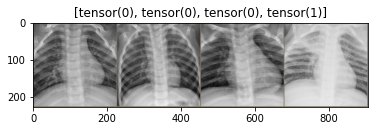

In [ ]:
# Get a batch of training data
inputs, classes = next(iter(bal_dataloaders['train']))
print(inputs.shape)
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
#imshow(out, title=[class_names[x] for x in classes])
imshow(out, title=[x for x in classes])

In [16]:
class TransferLearnigBasedModel:
    def __init__(self, model, dataloaders, criterion, optimizer, scheduler, num_epochs, dataset_size):
        self.EPOCHS = num_epochs
        self.dataloader = dataloaders
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.dataset_size = dataset_size
        self.epoch_losses = []
        self.epoch_list = []
    def train(self):
        since = time.time()

        best_model_wts = copy.deepcopy(self.model.state_dict())
        best_acc = 0.0

        for epoch in range(self.EPOCHS):
            print(f'Epoch {epoch}/{self.EPOCHS - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    self.model.train()  # Set model to training mode
                else:
                    self.model.eval()   # Set model to evaluate mode
                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in self.dataloader[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    
                    # zero the parameter gradients
                    self.optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = self.model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = self.criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            self.optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    self.scheduler.step()

                epoch_loss = running_loss / self.dataset_size[phase]
                epoch_acc = running_corrects.double() / self.dataset_size[phase]
                if phase == 'train':
                    self.epoch_losses.append(epoch_loss)
                    self.epoch_list.append(epoch)
                print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                    phase, epoch_loss, epoch_acc))
                print("Dataset size - ", self.dataset_size[phase], " Phase - ", phase )
                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(self.model.state_dict())

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed / 60} m, {time_elapsed % 60} s')
        print('Best val Acc: {:4f}'.format(best_acc))

        # load best model weights
        self.model.load_state_dict(best_model_wts)
        return self.model
        
    def test(self, model):
        test_acc_count = 0
        count = 0
        for inputs, labels in self.dataloader['test']:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = self.model(inputs)
            _, preds = torch.max(outputs, 1)
            for i in range(len(preds)):
                if preds[i] == labels[i]:
                    test_acc_count += 1
                count += 1

        return test_acc_count / count
    
    def plotLosses(self):
        plt.ylim([0, 1])
        plt.plot(self.epoch_list, self.epoch_losses)

# Main Code

## Google net and Resnet training and testing

In [17]:
googlenet = models.googlenet(pretrained=True)
googlenet = googlenet.to(device)
num_ftrs = googlenet.fc.in_features
googlenet.fc = nn.Linear(num_ftrs, 2).to(device)
optimizer = optim.Adam(googlenet.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
criterion = nn.CrossEntropyLoss()
epoch = 30

In [18]:
googleNetBalancedModel = TransferLearnigBasedModel(googlenet, bal_dataloaders, criterion, optimizer, exp_lr_scheduler, epoch, bal_dataset_sizes)

In [19]:
googleNetUnbalancedModel = TransferLearnigBasedModel(googlenet, unbal_dataloaders, criterion, optimizer, exp_lr_scheduler, epoch, unbal_dataset_sizes)

In [20]:
res18Model = models.resnet18(pretrained=True)
num_ftrs = res18Model.fc.in_features
res18Model.fc = nn.Linear(num_ftrs, 2).to(device)
res18Model = res18Model.to(device)
optimizer = optim.Adam(res18Model.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
criterion = nn.CrossEntropyLoss()
epoch = 30

In [21]:
resNet18BalancedModel =  TransferLearnigBasedModel(res18Model, bal_dataloaders, criterion, optimizer ,exp_lr_scheduler, epoch, bal_dataset_sizes)

In [22]:
resNet18UnbalancedModel =  TransferLearnigBasedModel(res18Model, unbal_dataloaders, criterion, optimizer ,exp_lr_scheduler, epoch, unbal_dataset_sizes)

In [23]:
res34Model = models.resnet34(pretrained=True)
num_ftrs = res34Model.fc.in_features
res34Model.fc = nn.Linear(num_ftrs, 2).to(device)
res34Model = res34Model.to(device)
optimizer = optim.Adam(res34Model.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
criterion = nn.CrossEntropyLoss()
epoch = 30

In [24]:
resNet34BalancedModel =  TransferLearnigBasedModel(res34Model, bal_dataloaders, criterion, optimizer ,exp_lr_scheduler, epoch, bal_dataset_sizes)

In [25]:
resNet34UnbalancedModel =  TransferLearnigBasedModel(res34Model, unbal_dataloaders, criterion, optimizer ,exp_lr_scheduler, epoch, unbal_dataset_sizes)

In [26]:
res50Model = models.resnet50(pretrained=True)
num_ftrs = res50Model.fc.in_features
res50Model.fc = nn.Linear(num_ftrs, 2).to(device)
res50Model = res50Model.to(device)
optimizer = optim.Adam(res50Model.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
criterion = nn.CrossEntropyLoss()
epoch = 30

In [27]:
resNet50BalancedModel =  TransferLearnigBasedModel(res50Model, bal_dataloaders, criterion, optimizer ,exp_lr_scheduler, epoch, bal_dataset_sizes)

In [28]:
resNet50UnbalancedModel =  TransferLearnigBasedModel(res50Model, unbal_dataloaders, criterion, optimizer ,exp_lr_scheduler, epoch, unbal_dataset_sizes)

## Training on balanced data

In [29]:
resultBalancedGoogleModel = googleNetBalancedModel.train()

Epoch 0/29
----------
train Loss: 0.2686 Acc: 0.9042
Dataset size -  2024  Phase -  train
val Loss: 0.2262 Acc: 0.9173
Dataset size -  508  Phase -  val

Epoch 1/29
----------
train Loss: 0.2084 Acc: 0.9165
Dataset size -  2024  Phase -  train
val Loss: 0.2052 Acc: 0.9075
Dataset size -  508  Phase -  val

Epoch 2/29
----------
train Loss: 0.1736 Acc: 0.9461
Dataset size -  2024  Phase -  train
val Loss: 0.8822 Acc: 0.6752
Dataset size -  508  Phase -  val

Epoch 3/29
----------
train Loss: 0.1545 Acc: 0.9521
Dataset size -  2024  Phase -  train
val Loss: 0.1649 Acc: 0.9311
Dataset size -  508  Phase -  val

Epoch 4/29
----------
train Loss: 0.1269 Acc: 0.9580
Dataset size -  2024  Phase -  train
val Loss: 0.1624 Acc: 0.9409
Dataset size -  508  Phase -  val

Epoch 5/29
----------
train Loss: 0.1079 Acc: 0.9639
Dataset size -  2024  Phase -  train
val Loss: 0.2507 Acc: 0.8996
Dataset size -  508  Phase -  val

Epoch 6/29
----------
train Loss: 0.1002 Acc: 0.9654
Dataset size -  2024  P

In [30]:
resultBalancedResnet18Model = resNet18BalancedModel.train()

Epoch 0/29
----------
train Loss: 0.2924 Acc: 0.8977
Dataset size -  2024  Phase -  train
val Loss: 0.2254 Acc: 0.9154
Dataset size -  508  Phase -  val

Epoch 1/29
----------
train Loss: 0.1976 Acc: 0.9338
Dataset size -  2024  Phase -  train
val Loss: 0.3046 Acc: 0.8819
Dataset size -  508  Phase -  val

Epoch 2/29
----------
train Loss: 0.2225 Acc: 0.9209
Dataset size -  2024  Phase -  train
val Loss: 0.4607 Acc: 0.8543
Dataset size -  508  Phase -  val

Epoch 3/29
----------
train Loss: 0.1851 Acc: 0.9417
Dataset size -  2024  Phase -  train
val Loss: 0.3127 Acc: 0.9055
Dataset size -  508  Phase -  val

Epoch 4/29
----------
train Loss: 0.1553 Acc: 0.9506
Dataset size -  2024  Phase -  train
val Loss: 0.3145 Acc: 0.9035
Dataset size -  508  Phase -  val

Epoch 5/29
----------
train Loss: 0.1754 Acc: 0.9417
Dataset size -  2024  Phase -  train
val Loss: 0.2945 Acc: 0.8819
Dataset size -  508  Phase -  val

Epoch 6/29
----------
train Loss: 0.1471 Acc: 0.9541
Dataset size -  2024  P

In [31]:
resultBalancedResnet34Model = resNet34BalancedModel.train()

Epoch 0/29
----------
train Loss: 0.3381 Acc: 0.8829
Dataset size -  2024  Phase -  train
val Loss: 0.3426 Acc: 0.8681
Dataset size -  508  Phase -  val

Epoch 1/29
----------
train Loss: 0.2185 Acc: 0.9308
Dataset size -  2024  Phase -  train
val Loss: 0.4880 Acc: 0.8661
Dataset size -  508  Phase -  val

Epoch 2/29
----------
train Loss: 0.1978 Acc: 0.9244
Dataset size -  2024  Phase -  train
val Loss: 0.4351 Acc: 0.8681
Dataset size -  508  Phase -  val

Epoch 3/29
----------
train Loss: 0.1860 Acc: 0.9363
Dataset size -  2024  Phase -  train
val Loss: 0.4364 Acc: 0.8799
Dataset size -  508  Phase -  val

Epoch 4/29
----------
train Loss: 0.1676 Acc: 0.9452
Dataset size -  2024  Phase -  train
val Loss: 0.2732 Acc: 0.9035
Dataset size -  508  Phase -  val

Epoch 5/29
----------
train Loss: 0.1354 Acc: 0.9570
Dataset size -  2024  Phase -  train
val Loss: 0.2540 Acc: 0.8976
Dataset size -  508  Phase -  val

Epoch 6/29
----------
train Loss: 0.1523 Acc: 0.9496
Dataset size -  2024  P

In [32]:
resultBalancedResnet50Model = resNet50BalancedModel.train()

Epoch 0/29
----------
train Loss: 0.3325 Acc: 0.8824
Dataset size -  2024  Phase -  train
val Loss: 0.5794 Acc: 0.8661
Dataset size -  508  Phase -  val

Epoch 1/29
----------
train Loss: 0.2665 Acc: 0.9106
Dataset size -  2024  Phase -  train
val Loss: 0.3511 Acc: 0.8819
Dataset size -  508  Phase -  val

Epoch 2/29
----------
train Loss: 0.2248 Acc: 0.9234
Dataset size -  2024  Phase -  train
val Loss: 0.3561 Acc: 0.8898
Dataset size -  508  Phase -  val

Epoch 3/29
----------
train Loss: 0.2246 Acc: 0.9224
Dataset size -  2024  Phase -  train
val Loss: 0.2848 Acc: 0.8898
Dataset size -  508  Phase -  val

Epoch 4/29
----------
train Loss: 0.2100 Acc: 0.9239
Dataset size -  2024  Phase -  train
val Loss: 0.2581 Acc: 0.8996
Dataset size -  508  Phase -  val

Epoch 5/29
----------
train Loss: 0.2117 Acc: 0.9289
Dataset size -  2024  Phase -  train
val Loss: 0.3224 Acc: 0.8642
Dataset size -  508  Phase -  val

Epoch 6/29
----------
train Loss: 0.2036 Acc: 0.9289
Dataset size -  2024  P

In [33]:
googleBalancedModelTestAcc = resNet18BalancedModel.test(resultBalancedResnet18Model)

In [34]:
resnet18BalancedModelTestAcc = resNet18BalancedModel.test(resultBalancedResnet18Model)

In [35]:
resnet34BalancedModelTestAcc = resNet34BalancedModel.test(resultBalancedResnet34Model)

In [36]:
resnet50BalancedModelTestAcc = resNet50BalancedModel.test(resultBalancedResnet50Model)

In [37]:
googleBalancedModelTestAcc

0.9274447949526814

In [38]:
resnet18BalancedModelTestAcc

0.9274447949526814

In [39]:
resnet34BalancedModelTestAcc

0.9337539432176656

In [40]:
resnet50BalancedModelTestAcc

0.9069400630914827

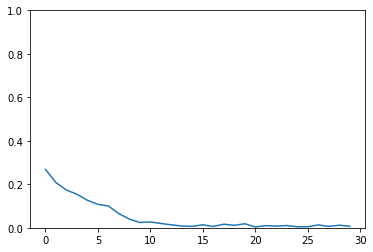

In [41]:
googleNetBalancedModel.plotLosses()

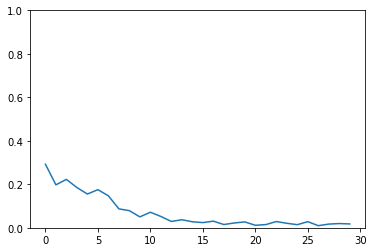

In [42]:
resNet18BalancedModel.plotLosses()

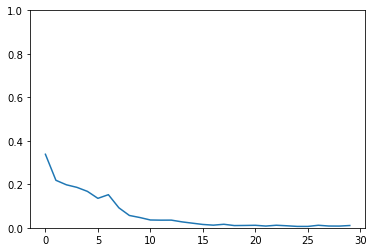

In [43]:
 resNet34BalancedModel.plotLosses()

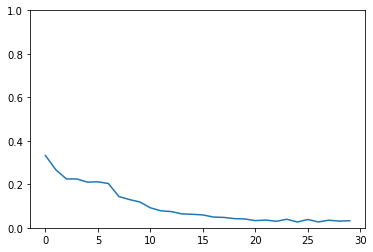

In [44]:
resNet50BalancedModel.plotLosses()

### Training on unbalanced data

In [45]:
resultUnbalancedGoogleModel = googleNetUnbalancedModel.train()

Epoch 0/29
----------
train Loss: 0.3822 Acc: 0.9077
Dataset size -  4714  Phase -  train
val Loss: 0.2180 Acc: 0.9350
Dataset size -  508  Phase -  val

Epoch 1/29
----------
train Loss: 0.3677 Acc: 0.9109
Dataset size -  4714  Phase -  train
val Loss: 0.2205 Acc: 0.9331
Dataset size -  508  Phase -  val

Epoch 2/29
----------
train Loss: 0.3721 Acc: 0.9139
Dataset size -  4714  Phase -  train
val Loss: 0.2677 Acc: 0.9252
Dataset size -  508  Phase -  val

Epoch 3/29
----------
train Loss: 0.3631 Acc: 0.9158
Dataset size -  4714  Phase -  train
val Loss: 0.1886 Acc: 0.9429
Dataset size -  508  Phase -  val

Epoch 4/29
----------
train Loss: 0.3366 Acc: 0.9202
Dataset size -  4714  Phase -  train
val Loss: 0.2243 Acc: 0.9390
Dataset size -  508  Phase -  val

Epoch 5/29
----------
train Loss: 0.3281 Acc: 0.9173
Dataset size -  4714  Phase -  train
val Loss: 0.2210 Acc: 0.9370
Dataset size -  508  Phase -  val

Epoch 6/29
----------
train Loss: 0.3330 Acc: 0.9158
Dataset size -  4714  P

In [46]:
resultUnbalancedResnet18Model = resNet18UnbalancedModel.train()

Epoch 0/29
----------
train Loss: 0.5735 Acc: 0.8854
Dataset size -  4714  Phase -  train
val Loss: 0.3507 Acc: 0.8937
Dataset size -  508  Phase -  val

Epoch 1/29
----------
train Loss: 0.6268 Acc: 0.8784
Dataset size -  4714  Phase -  train
val Loss: 0.3176 Acc: 0.9075
Dataset size -  508  Phase -  val

Epoch 2/29
----------
train Loss: 0.6006 Acc: 0.8795
Dataset size -  4714  Phase -  train
val Loss: 0.4807 Acc: 0.8898
Dataset size -  508  Phase -  val

Epoch 3/29
----------
train Loss: 0.6166 Acc: 0.8784
Dataset size -  4714  Phase -  train
val Loss: 0.4538 Acc: 0.8937
Dataset size -  508  Phase -  val

Epoch 4/29
----------
train Loss: 0.6091 Acc: 0.8776
Dataset size -  4714  Phase -  train
val Loss: 0.2795 Acc: 0.9094
Dataset size -  508  Phase -  val

Epoch 5/29
----------
train Loss: 0.5709 Acc: 0.8812
Dataset size -  4714  Phase -  train
val Loss: 0.3786 Acc: 0.9016
Dataset size -  508  Phase -  val

Epoch 6/29
----------
train Loss: 0.6271 Acc: 0.8770
Dataset size -  4714  P

In [47]:
resultUnbalancedResnet34Model = resNet34UnbalancedModel.train()

Epoch 0/29
----------
train Loss: 0.2597 Acc: 0.9289
Dataset size -  4714  Phase -  train
val Loss: 0.2968 Acc: 0.9094
Dataset size -  508  Phase -  val

Epoch 1/29
----------
train Loss: 0.2300 Acc: 0.9336
Dataset size -  4714  Phase -  train
val Loss: 0.3076 Acc: 0.9134
Dataset size -  508  Phase -  val

Epoch 2/29
----------
train Loss: 0.2346 Acc: 0.9328
Dataset size -  4714  Phase -  train
val Loss: 0.3157 Acc: 0.9035
Dataset size -  508  Phase -  val

Epoch 3/29
----------
train Loss: 0.2047 Acc: 0.9376
Dataset size -  4714  Phase -  train
val Loss: 0.2833 Acc: 0.9232
Dataset size -  508  Phase -  val

Epoch 4/29
----------
train Loss: 0.1978 Acc: 0.9412
Dataset size -  4714  Phase -  train
val Loss: 0.3034 Acc: 0.9252
Dataset size -  508  Phase -  val

Epoch 5/29
----------
train Loss: 0.1939 Acc: 0.9415
Dataset size -  4714  Phase -  train
val Loss: 0.2970 Acc: 0.9173
Dataset size -  508  Phase -  val

Epoch 6/29
----------
train Loss: 0.1896 Acc: 0.9468
Dataset size -  4714  P

In [48]:
resultUnbalancedResnet50Model = resNet50UnbalancedModel.train()

Epoch 0/29
----------
train Loss: 0.4358 Acc: 0.8867
Dataset size -  4714  Phase -  train
val Loss: 0.4111 Acc: 0.8780
Dataset size -  508  Phase -  val

Epoch 1/29
----------
train Loss: 0.4134 Acc: 0.8878
Dataset size -  4714  Phase -  train
val Loss: 0.3545 Acc: 0.8898
Dataset size -  508  Phase -  val

Epoch 2/29
----------
train Loss: 0.3781 Acc: 0.8980
Dataset size -  4714  Phase -  train
val Loss: 0.4324 Acc: 0.8701
Dataset size -  508  Phase -  val

Epoch 3/29
----------
train Loss: 0.3723 Acc: 0.8990
Dataset size -  4714  Phase -  train
val Loss: 0.3385 Acc: 0.8917
Dataset size -  508  Phase -  val

Epoch 4/29
----------
train Loss: 0.3658 Acc: 0.8969
Dataset size -  4714  Phase -  train
val Loss: 0.3373 Acc: 0.9016
Dataset size -  508  Phase -  val

Epoch 5/29
----------
train Loss: 0.3700 Acc: 0.8941
Dataset size -  4714  Phase -  train
val Loss: 0.3962 Acc: 0.8819
Dataset size -  508  Phase -  val

Epoch 6/29
----------
train Loss: 0.3459 Acc: 0.9022
Dataset size -  4714  P

In [49]:
googleUnbalancedModelTestAcc = googleNetUnbalancedModel.test(resultUnbalancedGoogleModel)

In [50]:
resnet18UnbalancedModelTestAcc = resNet18UnbalancedModel.test(resultUnbalancedResnet18Model)

In [51]:
resnet34UnbalancedModelTestAcc = resNet34UnbalancedModel.test(resultUnbalancedResnet34Model)

In [52]:
resnet50UnbalancedModelTestAcc = resNet50UnbalancedModel.test(resultUnbalancedResnet50Model)

In [53]:
googleUnbalancedModelTestAcc

0.9369085173501577

In [54]:
resnet18UnbalancedModelTestAcc

0.9227129337539433

In [55]:
resnet34UnbalancedModelTestAcc

0.9242902208201893

In [56]:
resnet50UnbalancedModelTestAcc

0.8974763406940063

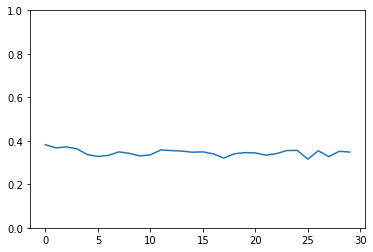

In [57]:
googleNetUnbalancedModel.plotLosses()

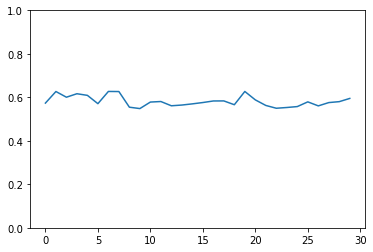

In [58]:
resNet18UnbalancedModel.plotLosses()

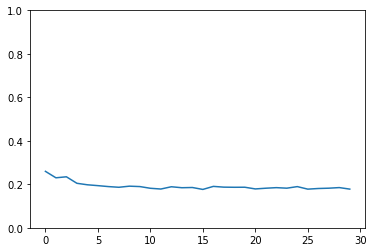

In [59]:
resNet34UnbalancedModel.plotLosses()

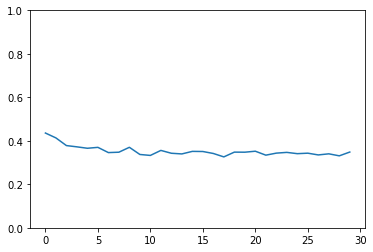

In [60]:
resNet50UnbalancedModel.plotLosses()

## CNN case1


Epoch 0/19
Accuracy of the network (Val): 86.02362204724409%, num_epoch : 0
Epoch 1/19
Accuracy of the network (Val): 90.15748031496064%, num_epoch : 1
Epoch 2/19
Accuracy of the network (Val): 90.94488188976378%, num_epoch : 2
Epoch 3/19
Accuracy of the network (Val): 88.58267716535433%, num_epoch : 3
Epoch 4/19
Accuracy of the network (Val): 90.74803149606299%, num_epoch : 4
Epoch 5/19
Accuracy of the network (Val): 90.35433070866142%, num_epoch : 5
Epoch 6/19
Accuracy of the network (Val): 85.8267716535433%, num_epoch : 6
Epoch 7/19
Accuracy of the network (Val): 90.74803149606299%, num_epoch : 7
Epoch 8/19
Accuracy of the network (Val): 89.1732283464567%, num_epoch : 8
Epoch 9/19
Accuracy of the network (Val): 91.14173228346456%, num_epoch : 9
Epoch 10/19
Accuracy of the network (Val): 89.76377952755905%, num_epoch : 10
Epoch 11/19
Accuracy of the network (Val): 89.56692913385827%, num_epoch : 11
Epoch 12/19
Accuracy of the network (Val): 90.15748031496064%, num_epoch : 12
Epoch 13

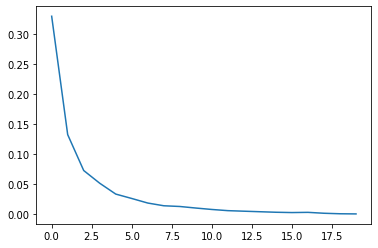

In [ ]:
device = torch.device("cpu")
device
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 3, 4)
        self.pool = nn.MaxPool2d(4, 4)
        self.conv2 = nn.Conv2d(3, 3, 3)
        self.fc1 = nn.Linear(3 * 13 * 13, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 2)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  
        x = self.pool(F.relu(self.conv2(x)))  
        x = x.view(-1, 3 * 13 * 13)           
        x = F.relu(self.fc1(x))              
        x = F.relu(self.fc2(x))              
        #x = torch.sigmoid(self.fc3(x))
        x = self.fc3(x)
        return x

model_bal = CNNModel().to(device)
batch_size = 16
num_epoch = 20
optimizer = Adam(model_bal.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

### Balanced
num = len(bal_dataloaders['train'])
loss_list = np.zeros(num_epoch)
num0 = 0
best_acc = 0.0
for epoch in range(num_epoch): 
    print(f'Epoch {epoch}/{num_epoch - 1}')
    count = 0
    sum = 0
    for inputs, labels in  bal_dataloaders['train']:
        inputs_train = inputs.to(device)
        labels_train = labels.to(device)
        count += 1
 
        tr_loss = 0
        output_train = model_bal(inputs_train)
        loss = criterion(output_train, labels_train)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        tr_loss = loss.item()
        num0 += 1
        sum += tr_loss
    loss_list[epoch] = sum/num0

        #print(f'Loss: {tr_loss} , count  {count}/{num}')
    n_samples = 0
    n_correct = 0
    for inputs, labels in bal_dataloaders['val']:
        inputs_val = inputs.to(device)
        labels_val = labels.to(device)
        predict_val = model_bal(inputs_val)
        _, predicted = torch.max(predict_val, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
    epoch_acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network (Val): {epoch_acc}%, num_epoch : {epoch}')
        # deep copy the model
    if epoch_acc > best_acc:
      best_acc = epoch_acc
      best_model_bal = copy.deepcopy(model_bal.state_dict())

plt.plot(loss_list)
# load best model weights
model_bal.load_state_dict(best_model_bal)
print(f'=======Test_balanced=======')
# Test
for inputs, labels in bal_dataloaders['test']:
  inputs_val = inputs.to(device)
  labels_val = labels.to(device)
  predict_val = model_bal(inputs_val)
  _, predicted = torch.max(predict_val, 1)
  n_samples += labels.size(0)
  n_correct += (predicted == labels).sum().item()
acc = 100.0 * n_correct / n_samples
print(f'Accuracy of the network (test): {acc}%')

### Unbalanced
model_unbal = CNNModel().to(device)
batch_size = 16
num_epoch = 20
optimizer = Adam(model_unbal.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

# Train 
num = len(unbal_dataloaders['train'])
loss_list = np.zeros(num_epoch)
num0 = 0
best_acc = 0.0
for epoch in range(num_epoch): 
    print(f'Epoch {epoch}/{num_epoch - 1}')
    count = 0
    sum = 0 
    for inputs, labels in  unbal_dataloaders['train']:
        inputs_train = inputs.to(device)
        labels_train = labels.to(device)
        count += 1
 
        tr_loss = 0
        output_train = model_unbal(inputs_train)
        loss = criterion(output_train, labels_train)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        tr_loss = loss.item()
        num0 += 1
        sum += tr_loss
    loss_list[epoch] = sum/num0
        #print(f'Loss: {tr_loss} , count  {count}/{num}')
    n_samples = 0
    n_correct = 0
    for inputs, labels in unbal_dataloaders['val']:
        inputs_val = inputs.to(device)
        labels_val = labels.to(device)
        predict_val = model_unbal(inputs_val)
        _, predicted = torch.max(predict_val, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
    epoch_acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network (Val): {epoch_acc}%, num_epoch : {epoch}')
        # deep copy the model
    if epoch_acc > best_acc:
      best_acc = epoch_acc
      best_model_bal = copy.deepcopy(model_unbal.state_dict())

# load best model weights
model_unbal.load_state_dict(best_model_bal)
print(f'=======Test_Unbalanced=======')
# Test
for inputs, labels in unbal_dataloaders['test']:
  inputs_val = inputs.to(device)
  labels_val = labels.to(device)
  predict_val = model_unbal(inputs_val)
  _, predicted = torch.max(predict_val, 1)
  n_samples += labels.size(0)
  n_correct += (predicted == labels).sum().item()
acc = 100.0 * n_correct / n_samples
print(f'Accuracy of the network (Test): {acc}%')


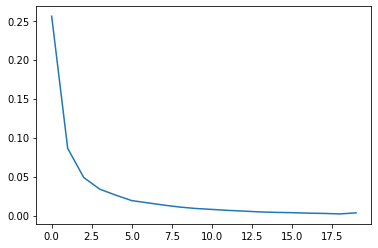

In [ ]:
plt.plot(loss_list)

##CNN case2

Epoch 0/19
Accuracy of the network (Val): 91.14173228346456%, num_epoch : 0
Epoch 1/19
Accuracy of the network (Val): 89.76377952755905%, num_epoch : 1
Epoch 2/19
Accuracy of the network (Val): 89.76377952755905%, num_epoch : 2
Epoch 3/19
Accuracy of the network (Val): 88.97637795275591%, num_epoch : 3
Epoch 4/19
Accuracy of the network (Val): 91.14173228346456%, num_epoch : 4
Epoch 5/19
Accuracy of the network (Val): 89.76377952755905%, num_epoch : 5
Epoch 6/19
Accuracy of the network (Val): 90.15748031496064%, num_epoch : 6
Epoch 7/19
Accuracy of the network (Val): 87.4015748031496%, num_epoch : 7
Epoch 8/19
Accuracy of the network (Val): 89.76377952755905%, num_epoch : 8
Epoch 9/19
Accuracy of the network (Val): 89.76377952755905%, num_epoch : 9
Epoch 10/19
Accuracy of the network (Val): 85.62992125984252%, num_epoch : 10
Epoch 11/19
Accuracy of the network (Val): 89.76377952755905%, num_epoch : 11
Epoch 12/19
Accuracy of the network (Val): 89.96062992125984%, num_epoch : 12
Epoch 1

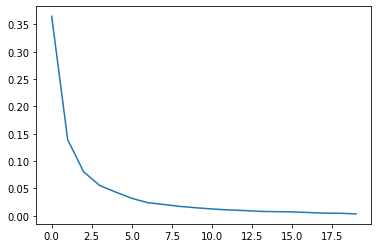

In [ ]:
device = torch.device("cpu")
device
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 3, 4)
        self.pool = nn.MaxPool2d(4, 4)
        self.conv2 = nn.Conv2d(3, 2, 3)
        self.fc1 = nn.Linear(2 * 13 * 13, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 2)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  
        x = self.pool(F.relu(self.conv2(x)))  
        x = x.view(-1, 2 * 13 * 13)           
        x = F.relu(self.fc1(x))              
        x = F.relu(self.fc2(x))              
        #x = torch.sigmoid(self.fc3(x))
        x = self.fc3(x)
        return x

model_bal = CNNModel().to(device)
batch_size = 16
num_epoch = 20
optimizer = Adam(model_bal.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

### Balanced
num = len(bal_dataloaders['train'])
loss_list = np.zeros(num_epoch)
num0 = 0
best_acc = 0.0
for epoch in range(num_epoch): 
    print(f'Epoch {epoch}/{num_epoch - 1}')
    count = 0
    sum = 0
    for inputs, labels in  bal_dataloaders['train']:
        inputs_train = inputs.to(device)
        labels_train = labels.to(device)
        count += 1
 
        tr_loss = 0
        output_train = model_bal(inputs_train)
        loss = criterion(output_train, labels_train)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        tr_loss = loss.item()
        num0 += 1
        sum += tr_loss
    loss_list[epoch] = sum/num0
        #print(f'Loss: {tr_loss} , count  {count}/{num}')
    n_samples = 0
    n_correct = 0
    for inputs, labels in bal_dataloaders['val']:
        inputs_val = inputs.to(device)
        labels_val = labels.to(device)
        predict_val = model_bal(inputs_val)
        _, predicted = torch.max(predict_val, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
    epoch_acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network (Val): {epoch_acc}%, num_epoch : {epoch}')
        # deep copy the model
    if epoch_acc > best_acc:
      best_acc = epoch_acc
      best_model_bal = copy.deepcopy(model_bal.state_dict())

plt.plot(loss_list)
# load best model weights
model_bal.load_state_dict(best_model_bal)
print(f'=======Test_balanced=======')
# Test
for inputs, labels in bal_dataloaders['test']:
  inputs_val = inputs.to(device)
  labels_val = labels.to(device)
  predict_val = model_bal(inputs_val)
  _, predicted = torch.max(predict_val, 1)
  n_samples += labels.size(0)
  n_correct += (predicted == labels).sum().item()
acc = 100.0 * n_correct / n_samples
print(f'Accuracy of the network (test): {acc}%')

### Unbalanced
model_unbal = CNNModel().to(device)
batch_size = 16
num_epoch = 20
optimizer = Adam(model_unbal.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

# Train 
num = len(unbal_dataloaders['train'])
loss_list = np.zeros(num_epoch)
num0 = 0
best_acc = 0.0
for epoch in range(num_epoch): 
    print(f'Epoch {epoch}/{num_epoch - 1}')
    count = 0
    sum = 0
    for inputs, labels in  unbal_dataloaders['train']:
        inputs_train = inputs.to(device)
        labels_train = labels.to(device)
        count += 1
 
        tr_loss = 0
        output_train = model_unbal(inputs_train)
        loss = criterion(output_train, labels_train)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        tr_loss = loss.item()
        num0 += 1
        sum += tr_loss
    loss_list[epoch] = sum/num0
        #print(f'Loss: {tr_loss} , count  {count}/{num}')
    n_samples = 0
    n_correct = 0
    for inputs, labels in unbal_dataloaders['val']:
        inputs_val = inputs.to(device)
        labels_val = labels.to(device)
        predict_val = model_unbal(inputs_val)
        _, predicted = torch.max(predict_val, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
    epoch_acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network (Val): {epoch_acc}%, num_epoch : {epoch}')
        # deep copy the model
    if epoch_acc > best_acc:
      best_acc = epoch_acc
      best_model_bal = copy.deepcopy(model_unbal.state_dict())


# load best model weights
model_unbal.load_state_dict(best_model_bal)
print(f'=======Test_Unbalanced=======')
# Test
for inputs, labels in unbal_dataloaders['test']:
  inputs_val = inputs.to(device)
  labels_val = labels.to(device)
  predict_val = model_unbal(inputs_val)
  _, predicted = torch.max(predict_val, 1)
  n_samples += labels.size(0)
  n_correct += (predicted == labels).sum().item()
acc = 100.0 * n_correct / n_samples
print(f'Accuracy of the network (Test): {acc}%')


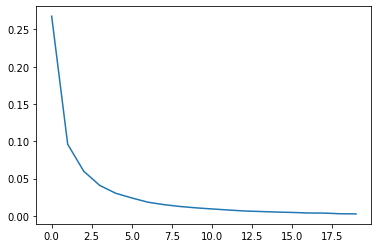

In [ ]:
plt.plot(loss_list)

## CNN case3

Epoch 0/19
Accuracy of the network (Val): 91.14173228346456%, num_epoch : 0
Epoch 1/19
Accuracy of the network (Val): 90.74803149606299%, num_epoch : 1
Epoch 2/19
Accuracy of the network (Val): 90.94488188976378%, num_epoch : 2
Epoch 3/19
Accuracy of the network (Val): 90.74803149606299%, num_epoch : 3
Epoch 4/19
Accuracy of the network (Val): 89.96062992125984%, num_epoch : 4
Epoch 5/19
Accuracy of the network (Val): 90.74803149606299%, num_epoch : 5
Epoch 6/19
Accuracy of the network (Val): 90.15748031496064%, num_epoch : 6
Epoch 7/19
Accuracy of the network (Val): 90.35433070866142%, num_epoch : 7
Epoch 8/19
Accuracy of the network (Val): 90.35433070866142%, num_epoch : 8
Epoch 9/19
Accuracy of the network (Val): 90.94488188976378%, num_epoch : 9
Epoch 10/19
Accuracy of the network (Val): 90.35433070866142%, num_epoch : 10
Epoch 11/19
Accuracy of the network (Val): 89.96062992125984%, num_epoch : 11
Epoch 12/19
Accuracy of the network (Val): 88.18897637795276%, num_epoch : 12
Epoch 

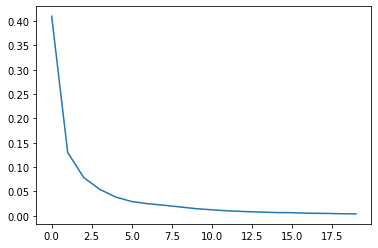

In [ ]:
device = torch.device("cpu")
device
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 3, 4)
        self.pool = nn.MaxPool2d(4, 4)
        self.conv2 = nn.Conv2d(3, 3, 3)
        self.fc1 = nn.Linear(3 * 13 * 13, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 8)
        self.fc4 = nn.Linear(8, 2)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  
        x = self.pool(F.relu(self.conv2(x)))  
        x = x.view(-1, 3 * 13 * 13)           
        x = F.relu(self.fc1(x))              
        x = F.relu(self.fc2(x))   
        x = F.relu(self.fc3(x))           
        #x = torch.sigmoid(self.fc3(x))
        x = self.fc4(x)
        return x

model_bal = CNNModel().to(device)
batch_size = 16
num_epoch = 20
optimizer = Adam(model_bal.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

### Balanced
num = len(bal_dataloaders['train'])
loss_list = np.zeros(num_epoch)
num0 = 0
best_acc = 0.0
for epoch in range(num_epoch): 
    print(f'Epoch {epoch}/{num_epoch - 1}')
    count = 0
    sum = 0
    for inputs, labels in  bal_dataloaders['train']:
        inputs_train = inputs.to(device)
        labels_train = labels.to(device)
        count += 1
 
        tr_loss = 0
        output_train = model_bal(inputs_train)
        loss = criterion(output_train, labels_train)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        tr_loss = loss.item()
        num0 += 1
        sum += tr_loss
    loss_list[epoch] = sum/num0
        #print(f'Loss: {tr_loss} , count  {count}/{num}')
    n_samples = 0
    n_correct = 0
    for inputs, labels in bal_dataloaders['val']:
        inputs_val = inputs.to(device)
        labels_val = labels.to(device)
        predict_val = model_bal(inputs_val)
        _, predicted = torch.max(predict_val, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
    epoch_acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network (Val): {epoch_acc}%, num_epoch : {epoch}')
        # deep copy the model
    if epoch_acc > best_acc:
      best_acc = epoch_acc
      best_model_bal = copy.deepcopy(model_bal.state_dict())

plt.plot(loss_list)
# load best model weights
model_bal.load_state_dict(best_model_bal)
print(f'=======Test_balanced=======')
# Test
for inputs, labels in bal_dataloaders['test']:
  inputs_val = inputs.to(device)
  labels_val = labels.to(device)
  predict_val = model_bal(inputs_val)
  _, predicted = torch.max(predict_val, 1)
  n_samples += labels.size(0)
  n_correct += (predicted == labels).sum().item()
acc = 100.0 * n_correct / n_samples
print(f'Accuracy of the network (test): {acc}%')

### Unbalanced
model_unbal = CNNModel().to(device)
batch_size = 16
num_epoch = 20
optimizer = Adam(model_unbal.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

# Train 
num = len(unbal_dataloaders['train'])
loss_list = np.zeros(num_epoch)
num0 = 0
best_acc = 0.0
for epoch in range(num_epoch): 
    print(f'Epoch {epoch}/{num_epoch - 1}')
    count = 0
    for inputs, labels in  unbal_dataloaders['train']:
        inputs_train = inputs.to(device)
        labels_train = labels.to(device)
        count += 1
 
        tr_loss = 0
        output_train = model_unbal(inputs_train)
        loss = criterion(output_train, labels_train)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        tr_loss = loss.item()
        num0 += 1
        sum += tr_loss
    loss_list[epoch] = sum/num0
        #print(f'Loss: {tr_loss} , count  {count}/{num}')
    n_samples = 0
    n_correct = 0
    for inputs, labels in unbal_dataloaders['val']:
        inputs_val = inputs.to(device)
        labels_val = labels.to(device)
        predict_val = model_unbal(inputs_val)
        _, predicted = torch.max(predict_val, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
    epoch_acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network (Val): {epoch_acc}%, num_epoch : {epoch}')
        # deep copy the model
    if epoch_acc > best_acc:
      best_acc = epoch_acc
      best_model_bal = copy.deepcopy(model_unbal.state_dict())


# load best model weights
model_unbal.load_state_dict(best_model_bal)
print(f'=======Test_Unbalanced=======')
# Test
for inputs, labels in unbal_dataloaders['test']:
  inputs_val = inputs.to(device)
  labels_val = labels.to(device)
  predict_val = model_unbal(inputs_val)
  _, predicted = torch.max(predict_val, 1)
  n_samples += labels.size(0)
  n_correct += (predicted == labels).sum().item()
acc = 100.0 * n_correct / n_samples
print(f'Accuracy of the network (Test): {acc}%')


## **SVM**

In [ ]:
import os
import glob

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mimg
%matplotlib inline
import cv2

from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
from PIL import Image
from pathlib import Path
from skimage.io import imread
from skimage.transform import resize

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
for dirname, _, filenames in os.walk(balancedFileDir):
    for filename in filenames:
        (os.path.join(dirname, filename))
print('Image files from "balanced" directory sucessfully joined!')
print(os.listdir(balancedFileDir))

Image files from "balanced" directory sucessfully joined!
['val', 'train', 'test']


In [ ]:
#Unbal
for dirname, _, filenames in os.walk(unbalancedFileDir):
    for filename in filenames:
        (os.path.join(dirname, filename))
print('Image files from "unbalanced" directory sucessfully joined!')
print(os.listdir(unbalancedFileDir))

Image files from "unbalanced" directory sucessfully joined!
['test', 'train', 'val']


In [ ]:
#Bal
# list of all the training images
bal_train_normal = Path(balancedFileDir + '/train/NORMAL').glob('*.jpeg')
bal_train_pneumonia = Path(balancedFileDir + '/train/PNEUMONIA').glob('*.jpeg')

# ---------------------------------------------------------------
# Train data format in (img_path, label) 
# Labels for [ the normal cases = 0 ] & [the pneumonia cases = 1]
# ---------------------------------------------------------------
normal_data = [(image, 0) for image in bal_train_normal]
pneumonia_data = [(image, 1) for image in bal_train_pneumonia]

bal_train_data = normal_data + pneumonia_data

# Get a pandas dataframe from the data we have in our list 
bal_train_data = pd.DataFrame(bal_train_data, columns=['image', 'label'])

# Checking the dataframe...
bal_train_data.head()

,image,label
0,/content/drive/Shareddrives/Groupproject/balan...,0
1,/content/drive/Shareddrives/Groupproject/balan...,0
2,/content/drive/Shareddrives/Groupproject/balan...,0
3,/content/drive/Shareddrives/Groupproject/balan...,0
4,/content/drive/Shareddrives/Groupproject/balan...,0


In [ ]:
#Unbal
# list of all the training images
unbal_train_normal = Path(unbalancedFileDir + '/train/NORMAL').glob('*.jpeg')
unbal_train_pneumonia = Path(unbalancedFileDir + '/train/PNEUMONIA').glob('*.jpeg')

# ---------------------------------------------------------------
# Train data format in (img_path, label) 
# Labels for [ the normal cases = 0 ] & [the pneumonia cases = 1]
# ---------------------------------------------------------------
normal_data = [(image, 0) for image in unbal_train_normal]
pneumonia_data = [(image, 1) for image in unbal_train_pneumonia]

unbal_train_data = normal_data + pneumonia_data

# Get a pandas dataframe from the data we have in our list 
unbal_train_data = pd.DataFrame(unbal_train_data, columns=['image', 'label'])

# Checking the dataframe...
unbal_train_data.head()

,image,label
0,/content/drive/Shareddrives/Groupproject/unbal...,0
1,/content/drive/Shareddrives/Groupproject/unbal...,0
2,/content/drive/Shareddrives/Groupproject/unbal...,0
3,/content/drive/Shareddrives/Groupproject/unbal...,0
4,/content/drive/Shareddrives/Groupproject/unbal...,0


In [ ]:
#bal
bal_train_data = bal_train_data.sample(frac=1., random_state=100).reset_index(drop=True)

# Checking the dataframe...
bal_train_data.head()

,image,label
0,/content/drive/Shareddrives/Groupproject/balan...,0
1,/content/drive/Shareddrives/Groupproject/balan...,1
2,/content/drive/Shareddrives/Groupproject/balan...,0
3,/content/drive/Shareddrives/Groupproject/balan...,0
4,/content/drive/Shareddrives/Groupproject/balan...,0


In [ ]:
#unbal
unbal_train_data = unbal_train_data.sample(frac=1., random_state=100).reset_index(drop=True)

# Checking the dataframe...
unbal_train_data.head()

,image,label
0,/content/drive/Shareddrives/Groupproject/unbal...,1
1,/content/drive/Shareddrives/Groupproject/unbal...,1
2,/content/drive/Shareddrives/Groupproject/unbal...,1
3,/content/drive/Shareddrives/Groupproject/unbal...,1
4,/content/drive/Shareddrives/Groupproject/unbal...,0


Total :  2024
1    1012
0    1012
Name: label, dtype: int64


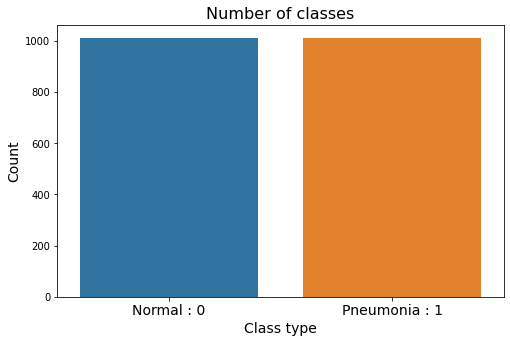

In [ ]:
#bal
# Counts for both classes
count_result = bal_train_data['label'].value_counts()
print('Total : ', len(bal_train_data))
print(count_result)

# Plot the results 
plt.figure(figsize=(8,5))
sns.countplot(x = 'label', data =  bal_train_data)
plt.title('Number of classes', fontsize=16)
plt.xlabel('Class type', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(range(len(count_result.index)), 
           ['Normal : 0', 'Pneumonia : 1'], 
           fontsize=14)
plt.show()

Total :  4714
1    3702
0    1012
Name: label, dtype: int64


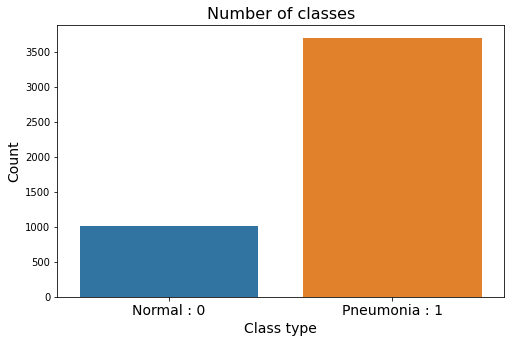

In [ ]:
#unbal
# Counts for both classes
count_result = unbal_train_data['label'].value_counts()
print('Total : ', len(unbal_train_data))
print(count_result)

# Plot the results 
plt.figure(figsize=(8,5))
sns.countplot(x = 'label', data =  unbal_train_data)
plt.title('Number of classes', fontsize=16)
plt.xlabel('Class type', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(range(len(count_result.index)), 
           ['Normal : 0', 'Pneumonia : 1'], 
           fontsize=14)
plt.show()

Balanced


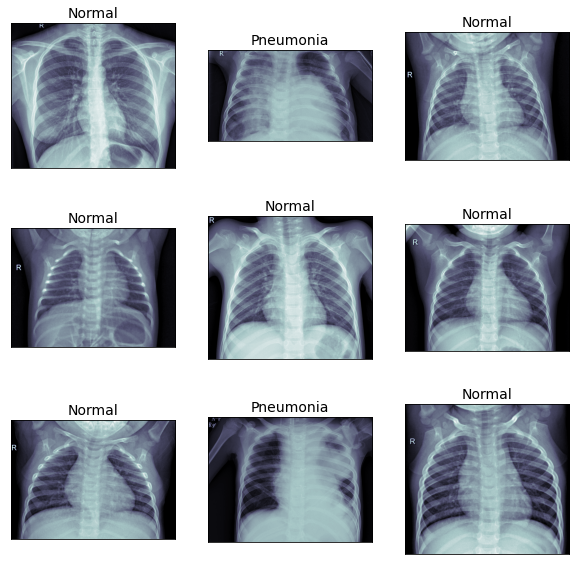

In [ ]:
print('Balanced')
fig, ax = plt.subplots(3, 3, figsize=(10,10))
for i, axi in enumerate(ax.flat):
    image = imread(bal_train_data.image[i])
    axi.imshow(image, cmap='bone')
    axi.set_title('Normal' if bal_train_data.label[i] == 0 else 'Pneumonia',
                  fontsize=14)
    axi.set(xticks=[], yticks=[])

Unbalanced


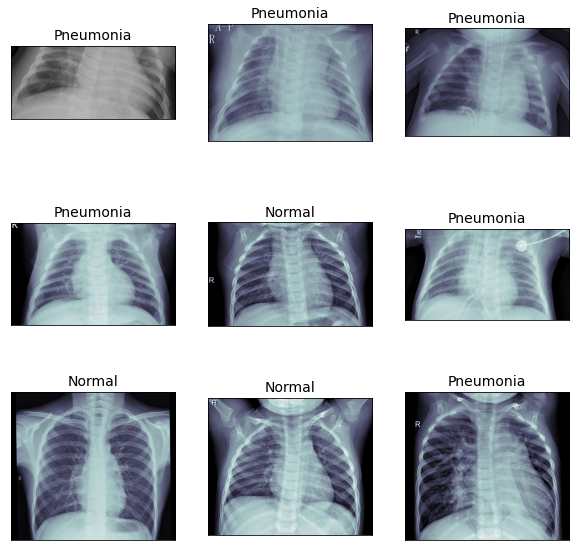

In [ ]:
#unbal
print('Unbalanced')
fig, ax = plt.subplots(3, 3, figsize=(10,10))
for i, axi in enumerate(ax.flat):
    image = imread(unbal_train_data.image[i])
    axi.imshow(image, cmap='bone')
    axi.set_title('Normal' if unbal_train_data.label[i] == 0 else 'Pneumonia',
                  fontsize=14)
    axi.set(xticks=[], yticks=[])

In [ ]:
def data_input(dataset):
    # print(dataset.shape)
    for image in dataset:
        im = cv2.imread(str(image))
        im = cv2.resize(im, (224,224))
        if im.shape[2] == 1:
            # np.dstack(): Stack arrays in sequence depth-wise 
            #              (along third axis).
            # https://docs.scipy.org/doc/numpy/reference/generated/numpy.dstack.html
            im = np.dstack([im, im, im])

        x_image = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        
        # Normalization
        x_image = x_image.astype(np.float32)/255.
        return x_image

In [ ]:
def load_data(files_dir):
    # list of the paths of all the image files
    normal = Path(files_dir + '/NORMAL').glob('*.jpeg')
    pneumonia = Path(files_dir + '/PNEUMONIA').glob('*.jpeg')

    # --------------------------------------------------------------
    # Data-paths' format in (img_path, label) 
    # labels : for [ Normal cases = 0 ] & [ Pneumonia cases = 1 ]
    # --------------------------------------------------------------
    
    normal_data = [(image, 0) for image in normal]
    pneumonia_data = [(image, 1) for image in pneumonia]
    img_data = normal_data + pneumonia_data
    # Get a pandas dataframe for the data paths h
    image_data = pd.DataFrame(img_data, columns=['image', 'label'])

    # Shuffle the data 
    image_data = image_data.sample(frac=1., random_state=100).reset_index(drop=True)

    x_images, y_labels = ([data_input(image_data.iloc[i][:]) for i in range(len(image_data))], 
                             [image_data.iloc[i][1] for i in range(len(image_data))])

    x_images = np.array(x_images)
    x_images = x_images.reshape(x_images.shape[0],x_images.shape[1]*x_images.shape[2]*x_images.shape[3])
    
    y_labels = np.array(y_labels)
    
    return x_images,y_labels

In [ ]:
import time
bal_imgtime = time.time()

bal_x_train, bal_y_train = load_data(files_dir= balancedFileDir + '/train')

print('balanced "train" imgae processing')
print(bal_x_train.shape)
print(bal_y_train.shape)

balanced "train" imgae processing
(2024, 150528)
(2024,)


In [ ]:
bal_x_test, bal_y_test= load_data(files_dir= balancedFileDir+ '/test')

bal_end = int(time.time() - bal_imgtime)

print('balanced "test" imgae processing')
print(bal_x_test.shape)
print(bal_y_test.shape)

print('balanced total image processing time: {:02d}:{:02d}:{:02d}'.format(bal_end // 3600, (bal_end % 3600 // 60), bal_end % 60))

balanced "test" imgae processing
(634, 150528)
(634,)
balanced total image processing time: 00:12:28


In [ ]:
unbal_imgtime = time.time()

unbal_x_train, unbal_y_train = load_data(files_dir= unbalancedFileDir + '/train')

print('unbalanced "train" imgae processing')
print(unbal_x_train.shape)
print(unbal_y_train.shape)

unbalanced "train" imgae processing
(4714, 150528)
(4714,)


In [ ]:
unbal_x_test, unbal_y_test= load_data(files_dir= unbalancedFileDir + '/test')

unbal_end = int(time.time() - unbal_imgtime)

print('unbalanced "test" imgae processing')
print(unbal_x_test.shape)
print(unbal_y_test.shape)

print('unbalanced image processing time: {:02d}:{:02d}:{:02d}'.format(unbal_end // 3600, (unbal_end % 3600 // 60), unbal_end % 60))

unbalanced "test" imgae processing
(634, 150528)
(634,)
unbalanced image processing time: 00:21:33


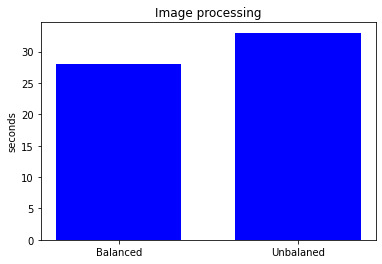

In [ ]:
y = [bal_end % 60, unbal_end % 60]
x = ['Balanced', 'Unbalaned']
plt.ylabel('seconds')
plt.title('Image processing')
plt.bar(x, y, width= 0.7, color ='blue')
plt.show()

In [ ]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA 
from sklearn.pipeline import make_pipeline
## refer -  https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

# Dimensional reduction
pca = PCA(n_components=150, whiten = True, random_state= 10)

# SVC 
## C:float, default=1.0
## kernel: {‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’}, default=’rbf’
## degreeint, default=3 *only 'poly' used
## gamma: {‘scale’, ‘auto’} or float, default=’scale’
## class_weight: ndarray of shape (n_classes,)

svc = SVC(kernel = 'rbf',class_weight = 'balanced')
model = make_pipeline(pca, svc)

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid ={'svc__C':[1,5,10,50],'svc__gamma':[0.0001,0.0005,0.001,0.005]}
grid = GridSearchCV(model, param_grid)

#bal
bal_svmtime = time.time()

grid.fit(bal_x_train, bal_y_train)

bal_svm_end = int(time.time() - bal_svmtime)
print('SVM with balanced time: {:02d}:{:02d}:{:02d}'.format(bal_svm_end // 3600, (bal_svm_end % 3600 // 60), bal_svm_end % 60))

result = pd.DataFrame(grid.cv_results_['params'])
result['mean_test_score'] = grid.cv_results_['mean_test_score']
result.sort_values(by='mean_test_score', ascending=False)

print('balanced best param: ' + format(grid.best_params_))

SVM with balanced time: 00:44:22
balanced best param: {'svc__C': 10, 'svc__gamma': 0.005}


In [ ]:
#unbal
unbal_svmtime = time.time()

grid.fit(unbal_x_train, unbal_y_train)

unbal_svm_end = int(time.time() - unbal_svmtime)
print('SVM with unbalanced time: {:02d}:{:02d}:{:02d}'.format(unbal_svm_end // 3600, (unbal_svm_end % 3600 // 60), unbal_svm_end % 60))

result = pd.DataFrame(grid.cv_results_['params'])
result['mean_test_score'] = grid.cv_results_['mean_test_score']
result.sort_values(by='mean_test_score', ascending=False)

print('unbalanced best param: ' + format(grid.best_params_))

In [ ]:
y = [bal_svm_end % 60,unbal_svm_end % 60]
x = ['Balanced SVM', 'Unbalaned SVM']
plt.ylabel('seconds')
plt.title(' SVM Time diff')
plt.legend(loc='upper right')
plt.bar(x, y, width= 0.7, color ='red')
plt.show()

In [ ]:
#bal
model = grid.best_estimator_
bal_yfit = model.predict(bal_x_test)

In [ ]:
#unbal
model = grid.best_estimator_
unbal_yfit = model.predict(unbal_x_test)

In [ ]:
#bal
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix,classification_report

print(classification_report(bal_y_test, bal_yfit, target_names= ['Pneumonia (Class 1)','Normal (Class 0)']))

In [ ]:
#unbal

print(classification_report(unbal_y_test, unbal_yfit, target_names= ['Pneumonia (Class 1)','Normal (Class 0)']))

In [ ]:
fig, ax = plt.subplots(4, 6)
for i, axi in enumerate(ax.flat):
    axi.imshow(bal_x_test[i].reshape(62, 47), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(target_names[bal_yfit = model.predict(bal_x_test)
[i]].split()[-1], color='black' if bal_yfit = model.predict(bal_x_test)
[i] == ytest[i] else 'red')
    
fig.suptitle('Predicted Names; Incorrect Labels in Red', size=14);

# **ANN**

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.5],[0.5])
    ]),
    'val': transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.5],[0.5])
    ]),
    'test': transforms.Compose([
       transforms.Grayscale(num_output_channels=1),
       transforms.Resize(256),
       transforms.CenterCrop(224),
       transforms.ToTensor(),
       transforms.Normalize([0.5],[0.5])
    ]),
}

In [ ]:
unbalanced_image_datasets = {x: datasets.ImageFolder(os.path.join(unbalancedFileDir, x), data_transforms[x]) for x in ['test','train','val']}
unbal_dataloaders = {x: torch.utils.data.DataLoader(unbalanced_image_datasets[x], batch_size=8,
                                             shuffle=True, num_workers=4)
              for x in ['test','train', 'val']}
unbal_dataset_sizes = {x: len(unbalanced_image_datasets[x]) for x in ['test','train','val']}
unbal_class_names = unbalanced_image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
balanced_image_datasets = {x: datasets.ImageFolder(os.path.join(balancedFileDir, x), data_transforms[x]) for x in ['test','train','val']}
bal_dataloaders = {x: torch.utils.data.DataLoader(balanced_image_datasets[x], batch_size=8,
                                             shuffle=True, num_workers=4)
              for x in ['test','train', 'val']}
bal_dataset_sizes = {x: len(balanced_image_datasets[x]) for x in ['test','train','val']}
bal_class_names = balanced_image_datasets['train'].classes

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
device

device(type='cuda', index=0)

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([8, 1, 224, 224])


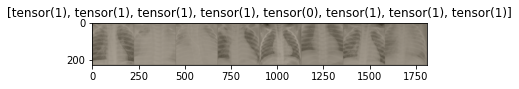

In [ ]:
# Get a batch of training data
inputs, classes = next(iter(unbal_dataloaders['train']))
print(inputs.shape)
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
#imshow(out, title=[class_names[x] for x in classes])
imshow(out, title=[x for x in classes])

# ANN 1-1: 4 hidden layers, 256;128;128;64, unbalanced

In [ ]:
# Create ANN Model
class ANNModel(nn.Module):
    def __init__(self, input_dim, hidden1_dim, hidden2_dim, hidden3_dim, hidden4_dim, output_dim):
        super(ANNModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden1_dim) 
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden1_dim, hidden2_dim)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden2_dim, hidden3_dim)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(hidden3_dim, hidden4_dim)
        self.relu4 = nn.ReLU()
        self.fc5 = nn.Linear(hidden4_dim, output_dim)    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        out = self.relu3(out)
        out = self.fc4(out)
        out = self.relu4(out)
        out = self.fc5(out)
        return out

# Hyperparameters
input_dim = 224*224
hidden1_dim = 256
hidden2_dim = 128
hidden3_dim = 128
hidden4_dim = 64
output_dim = 2
num_epochs = 20
learning_rate = 0.001

# Create ANN
model_unbal = ANNModel(input_dim, hidden1_dim, hidden2_dim, hidden3_dim, hidden4_dim, output_dim).to(device)

# Loss & Optimizer 
error = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_unbal.parameters(), lr=learning_rate)

epoch = current: 0 / total 20


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f351c36c710>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f351c36c710>
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151,

Accuracy of the network (Val): 92.32283464566929%, num_epoch : 0
epoch = current: 1 / total 20


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f351c36c710>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f351c36c710>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f351c36c710>
Traceback (most recent call last):
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f351c36c710>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    if w.is_alive():
  File "/usr/local/lib/python3.7

Accuracy of the network (Val): 88.38582677165354%, num_epoch : 1
epoch = current: 2 / total 20


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f351c36c710>
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f351c36c710>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f351c36c710>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    self._shutdown_workers()
    if w.is_alive():
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f351c36c710>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
  File "/usr/lib/python3.7/multiproces

Accuracy of the network (Val): 92.51968503937007%, num_epoch : 2
epoch = current: 3 / total 20


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f351c36c710>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f351c36c710>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f351c36c710>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f351c36c710>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
Traceback (most recent call last):
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dis

Accuracy of the network (Val): 93.30708661417323%, num_epoch : 3
epoch = current: 4 / total 20


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f351c36c710>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f351c36c710>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f351c36c710>
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f351c36c710>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
Traceback (most recent call last):
Traceback (most recent call last):
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    self._shutdown_workers()
    self._shutdown_worke

Accuracy of the network (Val): 91.53543307086615%, num_epoch : 4
epoch = current: 5 / total 20
Accuracy of the network (Val): 92.91338582677166%, num_epoch : 5
epoch = current: 6 / total 20
Accuracy of the network (Val): 88.77952755905511%, num_epoch : 6
epoch = current: 7 / total 20
Accuracy of the network (Val): 89.37007874015748%, num_epoch : 7
epoch = current: 8 / total 20
Accuracy of the network (Val): 90.94488188976378%, num_epoch : 8
epoch = current: 9 / total 20
Accuracy of the network (Val): 92.71653543307086%, num_epoch : 9
epoch = current: 10 / total 20
Accuracy of the network (Val): 90.55118110236221%, num_epoch : 10
epoch = current: 11 / total 20
Accuracy of the network (Val): 82.67716535433071%, num_epoch : 11
epoch = current: 12 / total 20
Accuracy of the network (Val): 90.74803149606299%, num_epoch : 12
epoch = current: 13 / total 20
Accuracy of the network (Val): 88.18897637795276%, num_epoch : 13
epoch = current: 14 / total 20
Accuracy of the network (Val): 92.9133858

<All keys matched successfully>

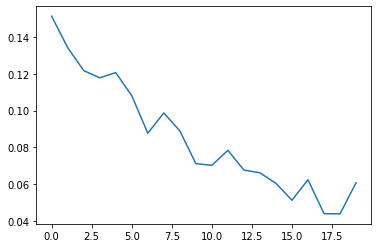

In [ ]:
# ANN model training
iteration_list = []
accuracy_list = []

num = len(unbal_dataloaders['train'])
loss_list = np.zeros(num*num_epochs)
best_acc = 0.0
loss_list = []

for epoch in range(num_epochs):
    
    running_loss = 0.0
    num0 = 0
    count = 0 
    print('epoch = current: {} / total {}'.format(epoch,num_epochs))
    for images, labels in unbal_dataloaders['train']:
        count += 1
        #print('count = current: {} / total {}'.format(count, len(unbal_dataloaders['train'].dataset)))
        images = images.view(-1,224*224) 
        images = images.to(device)
        labels = labels.to(device)

        # forward
        outputs = model_unbal(images) 
        loss = error(outputs, labels) # Calculate softmax and cross entropy loss
        
        # backward
        optimizer.zero_grad()
        loss.backward()

        # gradient descent or adam step
        optimizer.step()
        tr_loss = loss.item()
        running_loss += tr_loss
        num0 += 1
        
        #print('Loss: {:.4f}'.format(tr_loss))
    loss_list.append(running_loss / num0)
    
    n_samples = 0
    n_correct = 0
    for images, labels in unbal_dataloaders['val']:
        images = images.view(-1,224*224) 
        images = images.to(device)
        labels = labels.to(device)
        predict = model_unbal(images)
        _, predicted = torch.max(predict, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
    epoch_acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network (Val): {epoch_acc}%, num_epoch : {epoch}')
        # deep copy the model
    if epoch_acc > best_acc:
      best_acc = epoch_acc
      best_model_unbal = copy.deepcopy(model_unbal.state_dict())

plt.plot(loss_list)
model_unbal.load_state_dict(best_model_unbal)

In [ ]:
#check test accuracy
n_samples = 0
n_correct = 0
for images, labels in unbal_dataloaders['test']:
    images = images.view(-1,224*224) 
    images = images.to(device)
    labels = labels.to(device)
    predict = model_unbal(images)
    _, predicted = torch.max(predict, 1)
    n_samples += labels.size(0)
    n_correct += (predicted == labels).sum().item()
epoch_acc = 100.0 * n_correct / n_samples
print(f'=======Test Accuracy=======')
print(f'{epoch_acc}%')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


=======Test Accuracy=======
93.69085173501577%


# ANN 1-2: 4 hidden layers, 256;128;128;64, balanced



In [ ]:
# Create ANN Model
class ANNModel(nn.Module):
    def __init__(self, input_dim, hidden1_dim, hidden2_dim, hidden3_dim, hidden4_dim, output_dim):
        super(ANNModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden1_dim) 
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden1_dim, hidden2_dim)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden2_dim, hidden3_dim)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(hidden3_dim, hidden4_dim)
        self.relu4 = nn.ReLU()
        self.fc5 = nn.Linear(hidden4_dim, output_dim)    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        out = self.relu3(out)
        out = self.fc4(out)
        out = self.relu4(out)
        out = self.fc5(out)
        return out

# Hyperparameters
input_dim = 224*224
hidden1_dim = 256
hidden2_dim = 128
hidden3_dim = 128
hidden4_dim = 64
output_dim = 2
num_epochs = 20
learning_rate = 0.001

# Create ANN
model_bal = ANNModel(input_dim, hidden1_dim, hidden2_dim, hidden3_dim, hidden4_dim, output_dim).to(device)

# Loss & Optimizer 
error = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_bal.parameters(), lr=learning_rate)

epoch = current: 0 / total 20


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Accuracy of the network (Val): 87.00787401574803%, num_epoch : 0
epoch = current: 1 / total 20
Accuracy of the network (Val): 88.18897637795276%, num_epoch : 1
epoch = current: 2 / total 20
Accuracy of the network (Val): 90.35433070866142%, num_epoch : 2
epoch = current: 3 / total 20
Accuracy of the network (Val): 90.15748031496064%, num_epoch : 3
epoch = current: 4 / total 20
Accuracy of the network (Val): 92.32283464566929%, num_epoch : 4
epoch = current: 5 / total 20
Accuracy of the network (Val): 89.1732283464567%, num_epoch : 5
epoch = current: 6 / total 20
Accuracy of the network (Val): 90.15748031496064%, num_epoch : 6
epoch = current: 7 / total 20
Accuracy of the network (Val): 90.15748031496064%, num_epoch : 7
epoch = current: 8 / total 20
Accuracy of the network (Val): 90.35433070866142%, num_epoch : 8
epoch = current: 9 / total 20
Accuracy of the network (Val): 89.1732283464567%, num_epoch : 9
epoch = current: 10 / total 20
Accuracy of the network (Val): 90.94488188976378%, 

<All keys matched successfully>

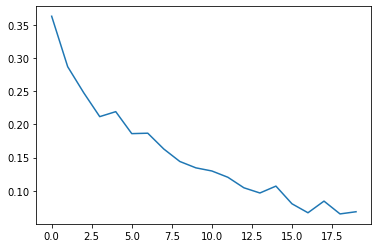

In [ ]:
# ANN model training
iteration_list = []
accuracy_list = []

num = len(bal_dataloaders['train'])
loss_list = np.zeros(num*num_epochs)
best_acc = 0.0
loss_list = []

for epoch in range(num_epochs):
    
    running_loss = 0.0
    num0 = 0
    count = 0 
    print('epoch = current: {} / total {}'.format(epoch,num_epochs))
    for images, labels in bal_dataloaders['train']:
        count += 1
        #print('count = current: {} / total {}'.format(count, len(bal_dataloaders['train'].dataset)))
        images = images.view(-1,224*224)
        images = images.to(device)
        labels = labels.to(device) 

        # forward
        outputs = model_bal(images) 
        loss = error(outputs, labels) # Calculate softmax and cross entropy loss
        
        # backward
        optimizer.zero_grad()
        loss.backward()

        # gradient descent or adam step
        optimizer.step()
        tr_loss = loss.item()
        running_loss += tr_loss
        num0 += 1
        
        #print('Loss: {:.4f}'.format(tr_loss))
    loss_list.append(running_loss / num0)
    
    n_samples = 0
    n_correct = 0
    for images, labels in bal_dataloaders['val']:
        images = images.view(-1,224*224)
        images = images.to(device)
        labels = labels.to(device)
        predict = model_bal(images)
        _, predicted = torch.max(predict, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
    epoch_acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network (Val): {epoch_acc}%, num_epoch : {epoch}')
        # deep copy the model
    if epoch_acc > best_acc:
      best_acc = epoch_acc
      best_model_bal = copy.deepcopy(model_bal.state_dict())

plt.plot(loss_list)
model_bal.load_state_dict(best_model_bal)

In [ ]:
#check test accuracy
n_samples = 0
n_correct = 0
for images, labels in bal_dataloaders['test']:
    images = images.view(-1,224*224) 
    images = images.to(device)
    labels = labels.to(device)
    predict = model_bal(images)
    _, predicted = torch.max(predict, 1)
    n_samples += labels.size(0)
    n_correct += (predicted == labels).sum().item()
epoch_acc = 100.0 * n_correct / n_samples
print(f'=======Test Accuracy=======')
print(f'{epoch_acc}%')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


=======Test Accuracy=======
90.85173501577287%


# ANN 2-1: 4 hidden layers, 512;256;128;64, unbalanced

In [ ]:
# Create ANN Model
class ANNModel(nn.Module):
    def __init__(self, input_dim, hidden1_dim, hidden2_dim, hidden3_dim, hidden4_dim, output_dim):
        super(ANNModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden1_dim) 
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden1_dim, hidden2_dim)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden2_dim, hidden3_dim)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(hidden3_dim, hidden4_dim)
        self.relu4 = nn.ReLU()
        self.fc5 = nn.Linear(hidden4_dim, output_dim)    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        out = self.relu3(out)
        out = self.fc4(out)
        out = self.relu4(out)
        out = self.fc5(out)
        return out

# Hyperparameters
input_dim = 224*224
hidden1_dim = 512
hidden2_dim = 256
hidden3_dim = 128
hidden4_dim = 64
output_dim = 2
num_epochs = 20
learning_rate = 0.001

# Create ANN
model_unbal = ANNModel(input_dim, hidden1_dim, hidden2_dim, hidden3_dim, hidden4_dim, output_dim).to(device)

# Loss & Optimizer 
error = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_unbal.parameters(), lr=learning_rate)

epoch = current: 0 / total 20


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f351c36c710>
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f351c36c710>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f351c36c710>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f351c36c710>
    self._shutdown_workers()
  File "/usr/local

Accuracy of the network (Val): 90.74803149606299%, num_epoch : 0
epoch = current: 1 / total 20
Accuracy of the network (Val): 92.51968503937007%, num_epoch : 1
epoch = current: 2 / total 20
Accuracy of the network (Val): 92.51968503937007%, num_epoch : 2
epoch = current: 3 / total 20
Accuracy of the network (Val): 90.74803149606299%, num_epoch : 3
epoch = current: 4 / total 20
Accuracy of the network (Val): 92.51968503937007%, num_epoch : 4
epoch = current: 5 / total 20
Accuracy of the network (Val): 92.32283464566929%, num_epoch : 5
epoch = current: 6 / total 20
Accuracy of the network (Val): 91.14173228346456%, num_epoch : 6
epoch = current: 7 / total 20
Accuracy of the network (Val): 93.30708661417323%, num_epoch : 7
epoch = current: 8 / total 20
Accuracy of the network (Val): 91.92913385826772%, num_epoch : 8
epoch = current: 9 / total 20
Accuracy of the network (Val): 89.96062992125984%, num_epoch : 9
epoch = current: 10 / total 20
Accuracy of the network (Val): 88.18897637795276%

<All keys matched successfully>

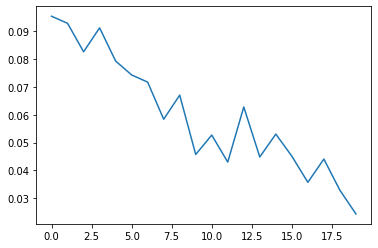

In [ ]:
# ANN model training
iteration_list = []
accuracy_list = []

num = len(unbal_dataloaders['train'])
loss_list = np.zeros(num*num_epochs)
best_acc = 0.0
loss_list = []

for epoch in range(num_epochs):
    
    running_loss = 0.0
    num0 = 0
    count = 0 
    print('epoch = current: {} / total {}'.format(epoch,num_epochs))
    for images, labels in unbal_dataloaders['train']:
        count += 1
        #print('count = current: {} / total {}'.format(count, len(unbal_dataloaders['train'].dataset)))
        images = images.view(-1,224*224)
        images = images.to(device)
        labels = labels.to(device) 

        # forward
        outputs = model_unbal(images) 
        loss = error(outputs, labels) # Calculate softmax and cross entropy loss
        
        # backward
        optimizer.zero_grad()
        loss.backward()

        # gradient descent or adam step
        optimizer.step()
        tr_loss = loss.item()
        running_loss += tr_loss
        num0 += 1
        
        #print('Loss: {:.4f}'.format(tr_loss))
    loss_list.append(running_loss / num0)
    
    n_samples = 0
    n_correct = 0
    for images, labels in unbal_dataloaders['val']:
        images = images.view(-1,224*224)
        images = images.to(device)
        labels = labels.to(device)
        predict = model_unbal(images)
        _, predicted = torch.max(predict, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
    epoch_acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network (Val): {epoch_acc}%, num_epoch : {epoch}')
        # deep copy the model
    if epoch_acc > best_acc:
      best_acc = epoch_acc
      best_model_unbal = copy.deepcopy(model_unbal.state_dict())

plt.plot(loss_list)
model_unbal.load_state_dict(best_model_unbal)

In [ ]:
#check test accuracy
n_samples = 0
n_correct = 0
for images, labels in unbal_dataloaders['test']:
    images = images.view(-1,224*224) 
    images = images.to(device)
    labels = labels.to(device)
    predict = model_unbal(images)
    _, predicted = torch.max(predict, 1)
    n_samples += labels.size(0)
    n_correct += (predicted == labels).sum().item()
epoch_acc = 100.0 * n_correct / n_samples
print(f'=======Test Accuracy=======')
print(f'{epoch_acc}%')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


=======Test Accuracy=======
93.37539432176656%


# ANN 2-2: 4 hidden layers, 512;256;128;64, balanced

In [ ]:
# Create ANN Model
class ANNModel(nn.Module):
    def __init__(self, input_dim, hidden1_dim, hidden2_dim, hidden3_dim, hidden4_dim, output_dim):
        super(ANNModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden1_dim) 
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden1_dim, hidden2_dim)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden2_dim, hidden3_dim)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(hidden3_dim, hidden4_dim)
        self.relu4 = nn.ReLU()
        self.fc5 = nn.Linear(hidden4_dim, output_dim)    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        out = self.relu3(out)
        out = self.fc4(out)
        out = self.relu4(out)
        out = self.fc5(out)
        return out
 
# Hyperparameters
input_dim = 224*224
hidden1_dim = 512
hidden2_dim = 256
hidden3_dim = 128
hidden4_dim = 64
output_dim = 2
num_epochs = 20
learning_rate = 0.001

# Create ANN
model_bal = ANNModel(input_dim, hidden1_dim, hidden2_dim, hidden3_dim, hidden4_dim, output_dim).to(device)

# Loss & Optimizer 
error = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_bal.parameters(), lr=learning_rate)

epoch = current: 0 / total 20


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Accuracy of the network (Val): 88.58267716535433%, num_epoch : 0
epoch = current: 1 / total 20
Accuracy of the network (Val): 92.1259842519685%, num_epoch : 1
epoch = current: 2 / total 20
Accuracy of the network (Val): 91.92913385826772%, num_epoch : 2
epoch = current: 3 / total 20
Accuracy of the network (Val): 87.79527559055119%, num_epoch : 3
epoch = current: 4 / total 20
Accuracy of the network (Val): 90.55118110236221%, num_epoch : 4
epoch = current: 5 / total 20
Accuracy of the network (Val): 90.35433070866142%, num_epoch : 5
epoch = current: 6 / total 20
Accuracy of the network (Val): 87.79527559055119%, num_epoch : 6
epoch = current: 7 / total 20
Accuracy of the network (Val): 83.07086614173228%, num_epoch : 7
epoch = current: 8 / total 20
Accuracy of the network (Val): 90.74803149606299%, num_epoch : 8
epoch = current: 9 / total 20
Accuracy of the network (Val): 88.97637795275591%, num_epoch : 9
epoch = current: 10 / total 20
Accuracy of the network (Val): 91.73228346456693%,

<All keys matched successfully>

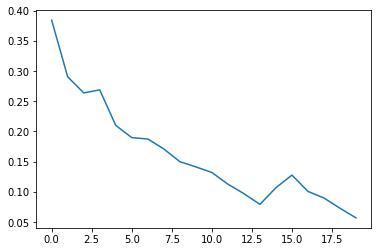

In [ ]:
# ANN model training
iteration_list = []
accuracy_list = []

num = len(bal_dataloaders['train'])
loss_list = np.zeros(num*num_epochs)
best_acc = 0.0
loss_list = []

for epoch in range(num_epochs):
    
    running_loss = 0.0
    num0 = 0
    count = 0 
    print('epoch = current: {} / total {}'.format(epoch,num_epochs))
    for images, labels in bal_dataloaders['train']:
        count += 1
        #print('count = current: {} / total {}'.format(count, len(bal_dataloaders['train'].dataset)))
        images = images.view(-1,224*224)
        images = images.to(device)
        labels = labels.to(device) 

        # forward
        outputs = model_bal(images) 
        loss = error(outputs, labels) # Calculate softmax and cross entropy loss
        
        # backward
        optimizer.zero_grad()
        loss.backward()

        # gradient descent or adam step
        optimizer.step()
        tr_loss = loss.item()
        running_loss += tr_loss
        num0 += 1
        
        #print('Loss: {:.4f}'.format(tr_loss))
    loss_list.append(running_loss / num0)
    
    n_samples = 0
    n_correct = 0
    for images, labels in bal_dataloaders['val']:
        images = images.view(-1,224*224)
        images = images.to(device)
        labels = labels.to(device)
        predict = model_bal(images)
        _, predicted = torch.max(predict, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
    epoch_acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network (Val): {epoch_acc}%, num_epoch : {epoch}')
        # deep copy the model
    if epoch_acc > best_acc:
      best_acc = epoch_acc
      best_model_bal = copy.deepcopy(model_bal.state_dict())

plt.plot(loss_list)
model_bal.load_state_dict(best_model_bal)

In [ ]:
#check test accuracy
n_samples = 0
n_correct = 0
for images, labels in bal_dataloaders['test']:
    images = images.view(-1,224*224) 
    images = images.to(device)
    labels = labels.to(device)
    predict = model_bal(images)
    _, predicted = torch.max(predict, 1)
    n_samples += labels.size(0)
    n_correct += (predicted == labels).sum().item()
epoch_acc = 100.0 * n_correct / n_samples
print(f'=======Test Accuracy=======')
print(f'{epoch_acc}%')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


=======Test Accuracy=======
93.69085173501577%


# ANN 3-1: 3 hidden layers, 256;128;64, unbalanced

In [ ]:
# Create ANN Model
class ANNModel(nn.Module):
    def __init__(self, input_dim, hidden1_dim, hidden2_dim, hidden3_dim, output_dim):
        super(ANNModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden1_dim) 
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden1_dim, hidden2_dim)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden2_dim, hidden3_dim)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(hidden3_dim, output_dim)
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        out = self.relu3(out)
        out = self.fc4(out)
        return out

# Hyperparameters
input_dim = 224*224
hidden1_dim = 256
hidden2_dim = 128
hidden3_dim = 64
output_dim = 2
num_epochs = 20
learning_rate = 0.001

# Create ANN
model_unbal = ANNModel(input_dim, hidden1_dim, hidden2_dim, hidden3_dim, output_dim).to(device)

# Loss & Optimizer 
error = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_unbal.parameters(), lr=learning_rate)

epoch = current: 0 / total 20


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Accuracy of the network (Val): 86.02362204724409%, num_epoch : 0
epoch = current: 1 / total 20
Accuracy of the network (Val): 86.81102362204724%, num_epoch : 1
epoch = current: 2 / total 20
Accuracy of the network (Val): 90.55118110236221%, num_epoch : 2
epoch = current: 3 / total 20
Accuracy of the network (Val): 81.10236220472441%, num_epoch : 3
epoch = current: 4 / total 20
Accuracy of the network (Val): 86.22047244094489%, num_epoch : 4
epoch = current: 5 / total 20
Accuracy of the network (Val): 91.73228346456693%, num_epoch : 5
epoch = current: 6 / total 20
Accuracy of the network (Val): 90.55118110236221%, num_epoch : 6
epoch = current: 7 / total 20
Accuracy of the network (Val): 91.14173228346456%, num_epoch : 7
epoch = current: 8 / total 20
Accuracy of the network (Val): 90.15748031496064%, num_epoch : 8
epoch = current: 9 / total 20
Accuracy of the network (Val): 86.81102362204724%, num_epoch : 9
epoch = current: 10 / total 20
Accuracy of the network (Val): 85.8267716535433%,

<All keys matched successfully>

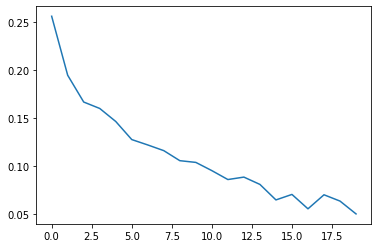

In [ ]:
# ANN model training
iteration_list = []
accuracy_list = []

num = len(unbal_dataloaders['train'])
loss_list = np.zeros(num*num_epochs)
best_acc = 0.0
loss_list = []

for epoch in range(num_epochs):
    
    running_loss = 0.0
    num0 = 0
    count = 0 
    print('epoch = current: {} / total {}'.format(epoch,num_epochs))
    for images, labels in unbal_dataloaders['train']:
        count += 1
        #print('count = current: {} / total {}'.format(count, len(unbal_dataloaders['train'].dataset)))
        images = images.view(-1,224*224)
        images = images.to(device)
        labels = labels.to(device) 

        # forward
        outputs = model_unbal(images) 
        loss = error(outputs, labels) # Calculate softmax and cross entropy loss
        
        # backward
        optimizer.zero_grad()
        loss.backward()

        # gradient descent or adam step
        optimizer.step()
        tr_loss = loss.item()
        running_loss += tr_loss
        num0 += 1
        
        #print('Loss: {:.4f}'.format(tr_loss))
    loss_list.append(running_loss / num0)
    
    n_samples = 0
    n_correct = 0
    for images, labels in unbal_dataloaders['val']:
        images = images.view(-1,224*224)
        images = images.to(device)
        labels = labels.to(device)
        predict = model_unbal(images)
        _, predicted = torch.max(predict, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
    epoch_acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network (Val): {epoch_acc}%, num_epoch : {epoch}')
        # deep copy the model
    if epoch_acc > best_acc:
      best_acc = epoch_acc
      best_model_unbal = copy.deepcopy(model_unbal.state_dict())

plt.plot(loss_list)
model_unbal.load_state_dict(best_model_unbal)

In [ ]:
#check test accuracy
n_samples = 0
n_correct = 0
for images, labels in unbal_dataloaders['test']:
    images = images.view(-1,224*224) 
    images = images.to(device)
    labels = labels.to(device)
    predict = model_unbal(images)
    _, predicted = torch.max(predict, 1)
    n_samples += labels.size(0)
    n_correct += (predicted == labels).sum().item()
epoch_acc = 100.0 * n_correct / n_samples
print(f'=======Test Accuracy=======')
print(f'{epoch_acc}%')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


=======Test Accuracy=======
93.37539432176656%


# ANN 3-2: 3 hidden layers, 256;128;64, balanced

In [ ]:
# Create ANN Model
class ANNModel(nn.Module):
    def __init__(self, input_dim, hidden1_dim, hidden2_dim, hidden3_dim, output_dim):
        super(ANNModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden1_dim) 
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden1_dim, hidden2_dim)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden2_dim, hidden3_dim)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(hidden3_dim, output_dim)
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        out = self.relu3(out)
        out = self.fc4(out)
        return out

# Hyperparameters
input_dim = 224*224
hidden1_dim = 256
hidden2_dim = 128
hidden3_dim = 64
output_dim = 2
num_epochs = 20
learning_rate = 0.001

# Create ANN
model_bal = ANNModel(input_dim, hidden1_dim, hidden2_dim, hidden3_dim, output_dim).to(device)

# Loss & Optimizer 
error = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_bal.parameters(), lr=learning_rate)

epoch = current: 0 / total 20


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Accuracy of the network (Val): 89.96062992125984%, num_epoch : 0
epoch = current: 1 / total 20
Accuracy of the network (Val): 91.73228346456693%, num_epoch : 1
epoch = current: 2 / total 20
Accuracy of the network (Val): 91.73228346456693%, num_epoch : 2
epoch = current: 3 / total 20
Accuracy of the network (Val): 87.20472440944881%, num_epoch : 3
epoch = current: 4 / total 20
Accuracy of the network (Val): 89.37007874015748%, num_epoch : 4
epoch = current: 5 / total 20
Accuracy of the network (Val): 94.09448818897638%, num_epoch : 5
epoch = current: 6 / total 20
Accuracy of the network (Val): 89.76377952755905%, num_epoch : 6
epoch = current: 7 / total 20
Accuracy of the network (Val): 91.33858267716535%, num_epoch : 7
epoch = current: 8 / total 20
Accuracy of the network (Val): 91.33858267716535%, num_epoch : 8
epoch = current: 9 / total 20
Accuracy of the network (Val): 90.74803149606299%, num_epoch : 9
epoch = current: 10 / total 20
Accuracy of the network (Val): 91.33858267716535%

<All keys matched successfully>

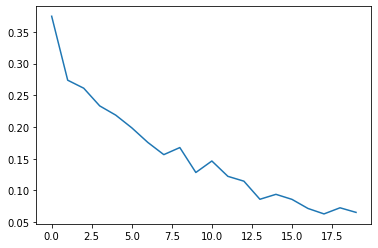

In [ ]:
# ANN model training
iteration_list = []
accuracy_list = []

num = len(bal_dataloaders['train'])
loss_list = np.zeros(num*num_epochs)
best_acc = 0.0
loss_list = []

for epoch in range(num_epochs):
    
    running_loss = 0.0
    num0 = 0
    count = 0 
    print('epoch = current: {} / total {}'.format(epoch,num_epochs))
    for images, labels in bal_dataloaders['train']:
        count += 1
        #print('count = current: {} / total {}'.format(count, len(bal_dataloaders['train'].dataset)))
        images = images.view(-1,224*224)
        images = images.to(device)
        labels = labels.to(device) 

        # forward
        outputs = model_bal(images) 
        loss = error(outputs, labels) # Calculate softmax and cross entropy loss
        
        # backward
        optimizer.zero_grad()
        loss.backward()

        # gradient descent or adam step
        optimizer.step()
        tr_loss = loss.item()
        running_loss += tr_loss
        num0 += 1
        
        #print('Loss: {:.4f}'.format(tr_loss))
    loss_list.append(running_loss / num0)
    
    n_samples = 0
    n_correct = 0
    for images, labels in bal_dataloaders['val']:
        images = images.view(-1,224*224)
        images = images.to(device)
        labels = labels.to(device)
        predict = model_bal(images)
        _, predicted = torch.max(predict, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
    epoch_acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network (Val): {epoch_acc}%, num_epoch : {epoch}')
        # deep copy the model
    if epoch_acc > best_acc:
      best_acc = epoch_acc
      best_model_bal = copy.deepcopy(model_bal.state_dict())

plt.plot(loss_list)
model_bal.load_state_dict(best_model_bal)

In [ ]:
#check test accuracy
n_samples = 0
n_correct = 0
for images, labels in bal_dataloaders['test']:
    images = images.view(-1,224*224) 
    images = images.to(device)
    labels = labels.to(device)
    predict = model_bal(images)
    _, predicted = torch.max(predict, 1)
    n_samples += labels.size(0)
    n_correct += (predicted == labels).sum().item()
epoch_acc = 100.0 * n_correct / n_samples
print(f'=======Test Accuracy=======')
print(f'{epoch_acc}%')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


=======Test Accuracy=======
94.79495268138801%
